In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [ ]:
training_file_path1 = '/content/drive/MyDrive/Colab Notebooks/M_16.csv'
training_file_path2 = '/content/drive/MyDrive/Colab Notebooks/ngc 3372.csv'
training_file_path3 = '/content/drive/MyDrive/Colab Notebooks/ngc 2244.csv'
validation_file_path = '/content/drive/MyDrive/Colab Notebooks/M_36-train.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [ ]:
#training data
training_data1 = load_data(training_file_path1)
training_data2 = load_data(training_file_path2)
training_data3 = load_data(training_file_path3)

#validation data
validation_data = load_data(validation_file_path)

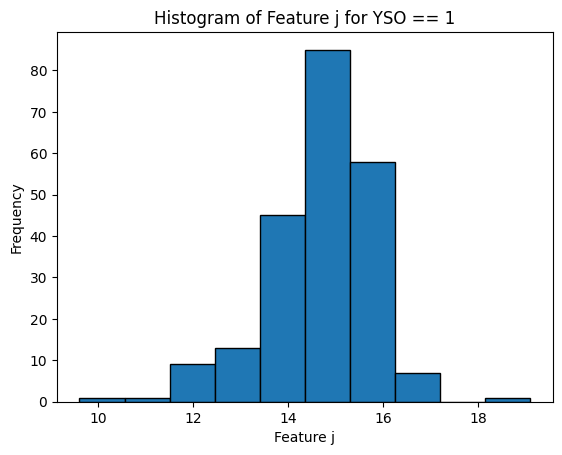

Skewness of feature j: nan


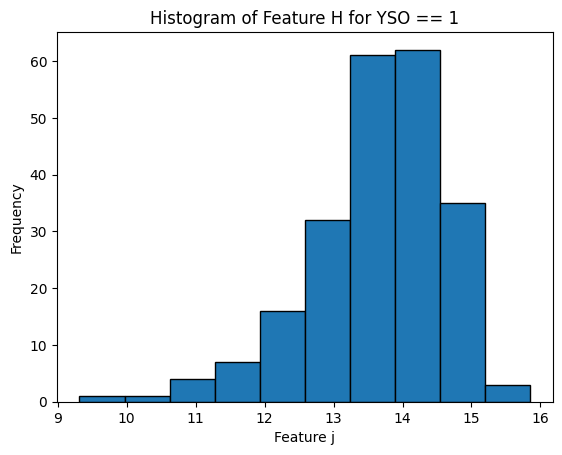

Skewness of feature j: nan


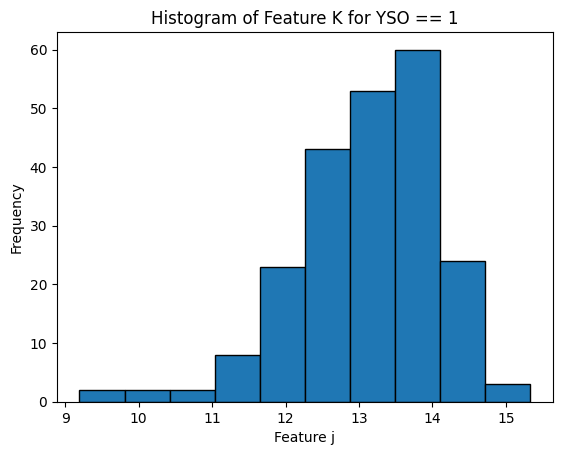

Skewness of feature k: nan


In [ ]:

plt.hist(training_data1[training_data1['YSO'] == 1]['j'], bins=10, edgecolor='black')
plt.title('Histogram of Feature j for YSO == 1')
plt.xlabel('Feature j')
plt.ylabel('Frequency')
plt.show()
skewness1 = skew(training_data1[training_data1['YSO'] == 1]['j'])
print("Skewness of feature j:", skewness1)

plt.hist(training_data1[training_data1['YSO'] == 1]['h'], bins=10, edgecolor='black')
plt.title('Histogram of Feature H for YSO == 1')
plt.xlabel('Feature j')
plt.ylabel('Frequency')
plt.show()
skewness2 = skew(training_data1[training_data1['YSO'] == 1]['h'])
print("Skewness of feature j:", skewness2)

plt.hist(training_data1[training_data1['YSO'] == 1]['k'], bins=10, edgecolor='black')
plt.title('Histogram of Feature K for YSO == 1')
plt.xlabel('Feature j')
plt.ylabel('Frequency')
plt.show()
skewness3 = skew(training_data1[training_data1['YSO'] == 1]['k'])
print("Skewness of feature k:", skewness3)

In [ ]:
# Compute medians function
def compute_medians(data):
    # Calculate the median values for non-YSOs and YSOs separately
    non_yso_median_j = data.loc[data['YSO'] == 0, 'j'].median()
    yso_median_j = data.loc[data['YSO'] == 1, 'j'].median()
    non_yso_median_h = data.loc[data['YSO'] == 0, 'h'].median()
    yso_median_h = data.loc[data['YSO'] == 1, 'h'].median()
    non_yso_median_k = data.loc[data['YSO'] == 0, 'k'].median()
    yso_median_k = data.loc[data['YSO'] == 1, 'k'].median()

    return (non_yso_median_j, yso_median_j, non_yso_median_h, yso_median_h, non_yso_median_k, yso_median_k)

In [ ]:
# Preprocessing function
def preprocess_data(data, scaler, medians, is_training=True):
    if {'j', 'h', 'k'}.issubset(data.columns):
        non_yso_median_j, yso_median_j, non_yso_median_h, yso_median_h, non_yso_median_k, yso_median_k = medians

        # Function to apply imputation based on YSO value
        def impute_value(row, column, non_yso_median, yso_median):
            if pd.isnull(row[column]):
                return non_yso_median if row['YSO'] == 0 else yso_median
            return row[column]

        # Impute missing values with the calculated medians for non-YSOs and YSOs
        data['j'] = data.apply(impute_value, axis=1, args=('j', non_yso_median_j, yso_median_j))
        data['h'] = data.apply(impute_value, axis=1, args=('h', non_yso_median_h, yso_median_h))
        data['k'] = data.apply(impute_value, axis=1, args=('k', non_yso_median_k, yso_median_k))

        # Scale the features
        data[['j', 'h', 'k']] = scaler.transform(data[['j', 'h', 'k']])

        # Create new features
        data['j_h'] = data['j'] - data['h']
        data['h_k'] = data['h'] - data['k']
        data['j_k'] = data['j'] - data['k']
    else:
        raise KeyError("Columns 'j', 'h', 'k' not found in the dataset.")

    X = data[['j_h', 'h_k', 'j_k']].values
    y = data['YSO'].values if 'YSO' in data.columns and is_training else None
    return X, y, data

In [ ]:

# Compute medians for training and validation data separately
training_medians1 = compute_medians(training_data1)
training_medians2 = compute_medians(training_data2)
training_medians3 = compute_medians(training_data3)
validation_medians = compute_medians(validation_data)

In [ ]:
# Initialize the scaler and fit it on the training data
scaler = StandardScaler()
scaler.fit(training_data1[['j', 'h', 'k']])
scaler.fit(training_data2[['j', 'h', 'k']])


StandardScaler()

In [ ]:
# Preprocess the entire training data
X_train1, y_train1, processed_training_data1 = preprocess_data(training_data1, scaler, training_medians1, is_training=True)
X_train2, y_train2, processed_training_data2 = preprocess_data(training_data2, scaler, training_medians2, is_training=True)
X_train3, y_train3, processed_training_data3 = preprocess_data(training_data3, scaler, training_medians2, is_training=True)

In [ ]:
def correct_reddening(data, E_BV):
    # Conversion factors from A_V to extinction in J, H, and K bands
    A_J_over_A_V = 0.282  # Typical value for the J band
    A_H_over_A_V = 0.190  # Typical value for the H band
    A_K_over_A_V = 0.114  # Typical value for the K band

    # Calculate R_J, R_H, and R_K using R_V
    R_J = A_J_over_A_V * 3.1
    R_H = A_H_over_A_V * 3.1
    R_K = A_K_over_A_V * 3.1

    # Calculate extinction values in each band
    A_J = R_J * E_BV
    A_H = R_H * E_BV
    A_K = R_K * E_BV

    if 'j' in data.columns:
        data['j'] -= A_J
    if 'h' in data.columns:
        data['h'] -= A_H
    if 'k' in data.columns:
        data['k'] -= A_K
    return data

In [ ]:
E_BV_train1 = 0.50
corrected_training_data1 = correct_reddening(training_data1, E_BV_train1)

In [ ]:
X_train1, y_train1, processed_training_data1 = preprocess_data(corrected_training_data1, scaler, training_medians1, is_training=True)

len(processed_training_data1)

236

In [ ]:
E_BV_train2 = 0.46
corrected_training_data2 = correct_reddening(training_data2, E_BV_train2)

In [ ]:
X_train2, y_train2, processed_training_data2 = preprocess_data(corrected_training_data2, scaler, training_medians2, is_training=True)

len(processed_training_data2)

115

In [ ]:
# Concatenate processed training data
processed_training_data = pd.concat([processed_training_data1, processed_training_data2], ignore_index=True)

# Combine feature matrices (numpy arrays)
X_train = np.concatenate([X_train1, X_train2], axis=0)

# Combine target vectors (numpy arrays)
y_train = np.concatenate([y_train1, y_train2], axis=0)

len(processed_training_data)

351

In [ ]:
E_BV_train3 = 0.46
corrected_training_data3 = correct_reddening(training_data3, E_BV_train3)

In [ ]:
X_train3, y_train3, processed_training_data3 = preprocess_data(corrected_training_data3, scaler, training_medians3, is_training=True)

len(processed_training_data3)

284

In [ ]:
# Concatenate processed training data
processed_training_data = pd.concat([processed_training_data, processed_training_data3], ignore_index=True)

# Combine feature matrices (numpy arrays)
X_train = np.concatenate([X_train, X_train3], axis=0)

# Combine target vectors (numpy arrays)
y_train = np.concatenate([y_train, y_train3], axis=0)

len(processed_training_data)

635

In [ ]:
# Generate new data points by adding random noise
def generate_new_data(X, y, n_per_point=10, noise_level=0.01):
    np.random.seed(42)  # For reproducibility
    new_X = []
    new_y = []
    for i in range(len(y)):
        for _ in range(n_per_point):
            new_X.append(X[i] + np.random.normal(scale=noise_level, size=X.shape[1]))
            new_y.append(y[i])
    return np.array(new_X), np.array(new_y)


In [ ]:
# Define the sample size
sample_size = len(y_train)
print(f"Total number of training data points after generating new data points: {sample_size}")

Total number of training data points after generating new data points: 635


In [ ]:
# Generate new data points
X_train, y_train = generate_new_data(X_train, y_train, n_per_point=10, noise_level=0.01)

In [ ]:
# Calculate total number of training data points after generating new data points
total_training_data_points = len(y_train)
print(f"Total number of training data points after generating new data points: {total_training_data_points}")


Total number of training data points after generating new data points: 6350


In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(len(y_train))

#columns = ['j_h', 'h_k', 'j_k']
#df_resampled = pd.DataFrame(X_train, columns=columns)
#df_resampled['YSO'] = y_train

# Save to CSV
#df_resampled.to_csv('resampled_data.csv', index=False)

8580


           j_h       h_k       j_k  YSO
0    -1.644370 -2.630378 -4.271856    1
1    -1.634107 -2.631337 -4.280674    1
2    -1.633545 -2.621321 -4.283027    1
3    -1.643911 -2.633630 -4.282990    1
4    -1.646917 -2.648128 -4.295582    1
...        ...       ...       ...  ...
6335 -1.143776 -0.174273 -1.324989    1
6336 -1.150431 -0.178014 -1.353297    1
6337 -1.161037 -0.183177 -1.349572    1
6338 -1.173277 -0.174899 -1.334997    1
6339 -1.170089 -0.187285 -1.326629    1

[4290 rows x 4 columns]


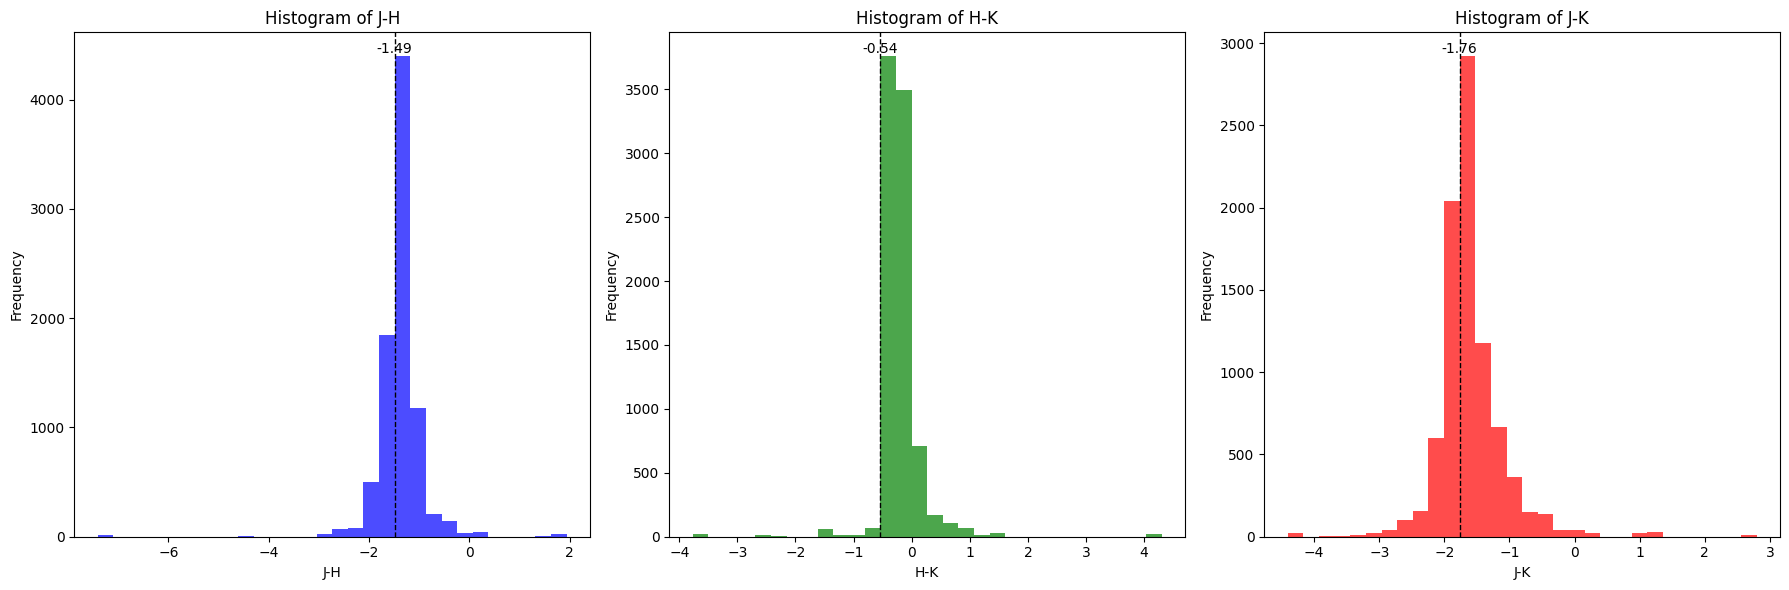

In [ ]:
# Assuming X_train is your resampled training data and y_train is the corresponding labels
# Create a DataFrame from your data
df_resampled = pd.DataFrame(X_train, columns=['j_h', 'h_k', 'j_k'])
df_resampled['YSO'] = y_train

# Filter the DataFrame to get only the rows where y_train (YSO) is 1
df_yso = df_resampled[df_resampled['YSO'] == 1]

# Print the filtered DataFrame
print(df_yso)

# Function to plot histograms and mark highest peaks
def plot_histogram_and_mark_peak(data, bins, color, xlabel, title):
    counts, bin_edges, _ = plt.hist(data, bins=bins, color=color, alpha=0.7)
    highest_peak_value = bin_edges[np.argmax(counts)]
    highest_peak_height = counts[np.argmax(counts)]
    plt.axvline(highest_peak_value, color='k', linestyle='dashed', linewidth=1)
    plt.text(highest_peak_value, highest_peak_height, f'{highest_peak_value:.2f}', ha='center', va='bottom')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)

# Plot histograms and mark highest peaks
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_histogram_and_mark_peak(df_resampled['j_h'], bins=30, color='blue', xlabel='J-H', title='Histogram of J-H')

plt.subplot(1, 3, 2)
plot_histogram_and_mark_peak(df_resampled['h_k'], bins=30, color='green', xlabel='H-K', title='Histogram of H-K')

plt.subplot(1, 3, 3)
plot_histogram_and_mark_peak(df_resampled['j_k'], bins=30, color='red', xlabel='J-K', title='Histogram of J-K')

plt.tight_layout()
plt.show()


In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)

In [ ]:
# Perform RandomizedSearchCV with StratifiedShuffleSplit for cross-validation
cross_val_setup = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions,
                                   n_iter=50, cv=cross_val_setup, verbose=1, random_state=42, n_jobs=-1)

In [ ]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=None),
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=1)

In [ ]:
# Best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [ ]:
# Best estimator from RandomizedSearchCV
best_rf_classifier = random_search.best_estimator_

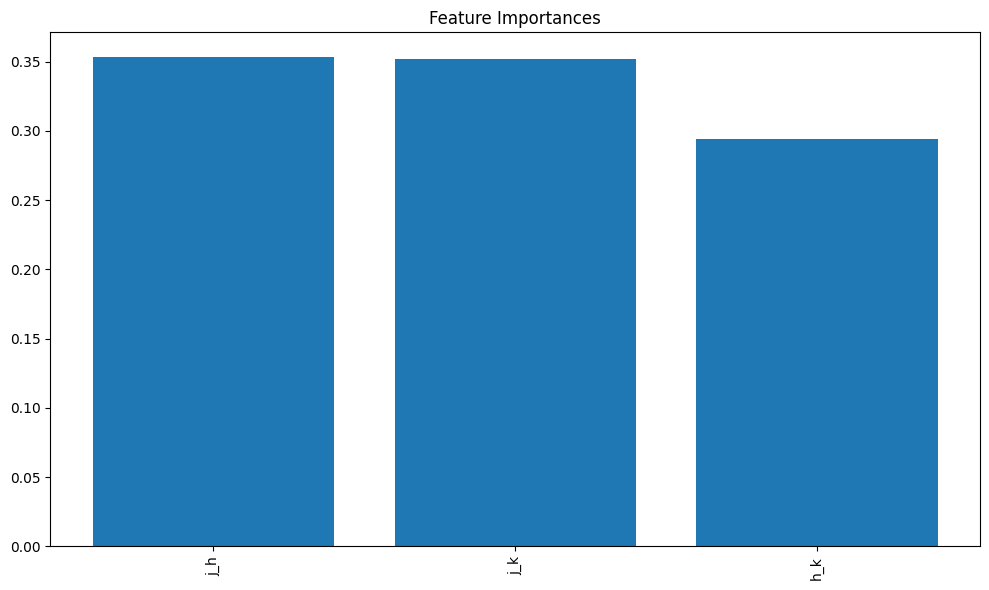

In [ ]:
# Assuming you have a list of feature names
feature_names_list = ["j_h", "h_k", "j_k"]  # Replace with your actual feature names

# Get feature importances from the best estimator
importances = best_rf_classifier.feature_importances_

# Visualize the feature importances
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names_list)[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(best_rf_classifier.estimators_[0], out_file=None,
                           feature_names=feature_names_list,
                           class_names=best_rf_classifier.classes_.astype(str),
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("best_tree", format="png")
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.58179 to fit


In [ ]:
cv_scores = cross_val_score(best_rf_classifier, X_train, y_train, cv=cross_val_setup, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores for the 5 splits: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())
print("Standard deviation of cross-validation score: ", cv_scores.std())



Cross-validation scores for the 5 splits:  [0.88073038 0.88111888 0.88344988 0.87723388 0.88500389]
Mean cross-validation score:  0.8815073815073816
Standard deviation of cross-validation score:  0.002646369287634253


### Validation Data Application

In [ ]:
# Preprocess the validation data
X_val, y_val, _ = preprocess_data(validation_data, scaler, validation_medians, is_training=True)

In [ ]:
E_BV_val = 0.25  # Example value for E(B-V)
corrected_val_data = correct_reddening(validation_data, E_BV_val)

In [ ]:
X_val, y_val, processed_val_data = preprocess_data(corrected_val_data, scaler, validation_medians, is_training=True)

In [ ]:
# Predict YSO on validation data
y_val_pred = best_rf_classifier.predict(X_val)

In [ ]:
# Calculate test accuracy on predicted YSO with the validation dataset
validation_accuracy = accuracy_score(y_val, y_val_pred)

# Generate classification report
report = classification_report(y_val, y_val_pred, target_names=['Non-YSO', 'YSO'])

In [ ]:
# Print the results
print(f"Validation Accuracy: {validation_accuracy:.10f}")
print("Classification Report:")
print(report)


Validation Accuracy: 0.5164835165
Classification Report:
              precision    recall  f1-score   support

     Non-YSO       0.63      0.47      0.54        55
         YSO       0.42      0.58      0.49        36

    accuracy                           0.52        91
   macro avg       0.53      0.53      0.52        91
weighted avg       0.55      0.52      0.52        91



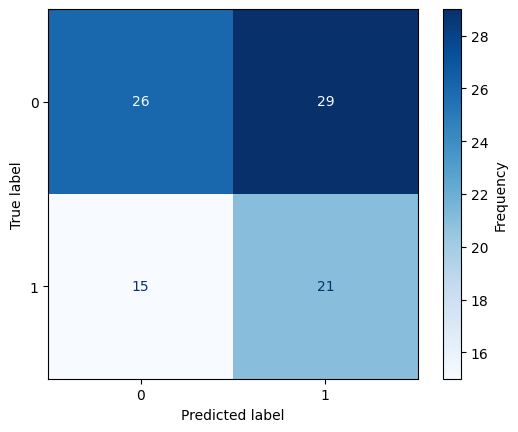

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Label the color bar
colorbar = ax.images[-1].colorbar
colorbar.set_label('Frequency')

plt.show()


### Raw Data Application

In [ ]:
raw_unlabeled_data_path = '/content/drive/MyDrive/Colab Notebooks/2MASS NGC 5288 (0.20 degrees).csv'

In [ ]:
raw_unlabeled_data = load_data(raw_unlabeled_data_path)

In [ ]:
# Apply reddening correction only to raw data
E_BV_raw = 0.45
raw_unlabeled_data = correct_reddening(raw_unlabeled_data, E_BV_raw)

In [ ]:
X_processed_raw, y_processed_raw, processed_raw_data = preprocess_data(raw_unlabeled_data, scaler, training_medians1, is_training=False)

In [ ]:
# Predict YSO on processed raw data
y_processed_raw_pred = best_rf_classifier.predict(X_processed_raw)

# Probability of YSO on processed raw data
y_processed_raw_probabilities = best_rf_classifier.predict_proba(X_processed_raw)
y_processed_raw_yso_probabilities = y_processed_raw_probabilities[:, 1]

raw_unlabeled_data['Predicted YSO'] = y_processed_raw_pred
raw_unlabeled_data['YSO Probability'] = y_processed_raw_yso_probabilities

number_of_ysos = (raw_unlabeled_data['Predicted YSO'] == 1).sum()
print(f"Number of YSOs in the raw data: {number_of_ysos}")

Number of YSOs in the raw data: 346


In [ ]:
def compute_spectral_index(j_mag, h_mag, k_mag):
    lambda_j = 1.235
    lambda_h = 1.662
    lambda_k = 2.159
    flux_j = 10 ** (-0.4 * j_mag)
    flux_h = 10 ** (-0.4 * h_mag)
    flux_k = 10 ** (-0.4 * k_mag)
    alpha_jh = np.log(flux_j / flux_h) / np.log(lambda_j / lambda_h)
    alpha_hk = np.log(flux_h / flux_k) / np.log(lambda_h / lambda_k)
    return alpha_jh, alpha_hk

In [ ]:
# Define the updated classify_yso function
def classify_yso(alpha):
    if alpha == 'undetectable':
        return 'Class 0'
    elif alpha > 0.3:
        return 'Class I'
    elif 0.3 >= alpha > -0.3:
        return 'Flat Spectrum'
    elif -0.3 >= alpha > -1.6:
        return 'Class II'
    else:
        return 'Class III'

In [ ]:
# Compute the spectral index for each row in the raw data
spectral_indices = raw_unlabeled_data.apply(
    lambda row: compute_spectral_index(row['j'], row['h'], row['k']), axis=1)

# Split the computed spectral indices into two separate columns
raw_unlabeled_data[['Alpha_JH', 'Alpha_HK']] = pd.DataFrame(spectral_indices.tolist(), index=raw_unlabeled_data.index)

# Add YSO_Class to the DataFrame based on Alpha_JH
raw_unlabeled_data['YSO_Class'] = raw_unlabeled_data.apply(
    lambda row: classify_yso(row['Alpha_JH']) if row['Predicted YSO'] == 1 else 'Non_YSO', axis=1)


In [ ]:
# Save the raw data with predictions, probabilities, and spectral indices to a new file
raw_unlabeled_data.to_csv('raw_data_with_predictions_probabilities_and_spectral_indices_corrected_mag.csv', index=False)

In [ ]:
def plot_color_color_diagram(data):
    class_order = ['Non_YSO','Class I', 'Flat Spectrum', 'Class II', 'Class III']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(class_order)))
    plt.figure(figsize=(10, 6))
    for cls, color in zip(class_order, colors):
        subset = data[data['YSO_Class'] == cls]
        plt.scatter(subset['j_h'], subset['h_k'], c=[color], label=cls, edgecolor='k', alpha=0.6)
    plt.xlabel('J-H')
    plt.ylabel('H-K')
    plt.title('Color-Color Diagram (J-H vs. H-K)')
    plt.legend()
    plt.grid(True)
    #plt.savefig('color_color_diagram.png')
    plt.show()

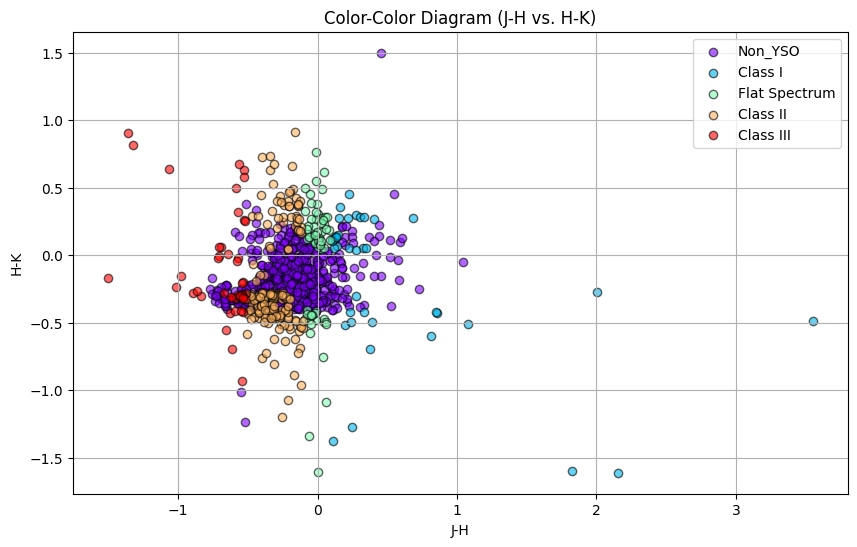

In [ ]:
plot_color_color_diagram(raw_unlabeled_data)